 # JRA Exploratory Data Analysis (EDA)

 Notebook ini bertujuan untuk menganalisis karakteristik data balap kuda JRA setelah proses Preprocessing.
 Fokus utama adalah menemukan pola yang bisa menjadi fitur (feature) untuk pemodelan.

 **Target Analisis:**
 1. Distribusi Target (Win/Rank).
 2. Hubungan Odds & Popularity (Ninki) dengan Kemenangan.
 3. Bias Lintasan: Pengaruh Nomor Gerbang (Gate/Waku).
 4. Strategi Lari: Pengaruh Gaya Lari (Leg Type/Kyaku-shitsu).
 5. Kondisi Trek: Pengaruh Cuaca dan Kondisi Tanah terhadap Waktu.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Konfigurasi Visualisasi
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Jika ada teks Jepang yang tidak muncul di plot, uncomment baris di bawah ini
# import japanize_matplotlib

In [37]:
file_path = '../data/processed/race_result_cleaned.csv' 

df = pd.read_csv(file_path)
print("Data berhasil dimuat!")
print(f"Jumlah Baris: {df.shape[0]}, Jumlah Kolom: {df.shape[1]}")
# ==========================================
# [SISIPKAN FILTER DI SINI]
# ==========================================
# Filter: Ambil hanya Flat Race (Buang Jump Race)
# Tanda '~' artinya "KECUALI" atau "NEGASI"
# Pastikan Anda sudah menjalankan Mapping di Notebook 01 agar 'Jump' terdeteksi di race_class
df = df[~df['race_class'].str.contains('Jump', case=False, na=False)]

print(f"Sisa Data (Flat Race Only): {len(df)} baris")
# ==========================================

# 2. PENTING: Urutkan data berdasarkan Kuda dan Tanggal
# Kita butuh urutan waktu yang benar untuk menghitung sejarah (masa lalu -> masa kini)
# reset_index(drop=True) wajib agar index kembali rapi dari 0, 1, 2... setelah pembuangan data
df = df.sort_values(by=['horse_name', 'date']).reset_index(drop=True)

df.head(3)
df.head()


C:\Users\ACER\AppData\Local\Temp\ipykernel_6340\2087606488.py:3: DtypeWarning: Columns (13,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Data berhasil dimuat!
Jumlah Baris: 1611896, Jumlah Kolom: 47
Sisa Data (Flat Race Only): 1561206 baris


,race_id,date,start_time,venue,holding_number,holding_days,race_name,race_class,race_type,grade_race_count,...,popularity,horse_weight,weight_change,prize,time_seconds,horse_name_eng,jockey_eng,owner_eng,trainer_eng,race_name_eng
0,201206010606,2012-01-21,12:50:00,Nakayama,1,6,3歳新馬,3yo Newcomer,NaN,NaN,...,13.0,454.0,0.0,90.0,102.6,Aiaiendebaa,Heiya Yuu,Saitou Takashi,Kojima Shigeyuki,3 Toshi Shinba
1,201205020805,2012-05-13,12:20:00,Tokyo,2,8,3歳未勝利,3yo Maiden,NaN,NaN,...,6.0,450.0,-4.0,NaN,125.8,Aiaiendebaa,Uiria,Saitou Takashi,Kojima Shigeyuki,3 Toshi Mishouri
2,201203020204,2012-06-17,11:40:00,Fukushima,2,2,3歳未勝利,3yo Maiden,NaN,NaN,...,9.0,444.0,-6.0,NaN,123.1,Aiaiendebaa,Tanaka Katsuharu,Saitou Takashi,Kojima Shigeyuki,3 Toshi Mishouri
3,201204020204,2012-07-15,11:40:00,Niigata,2,2,3歳未勝利,3yo Maiden,NaN,NaN,...,9.0,444.0,0.0,NaN,117.1,Aiaiendebaa,Yoshida Yutaka,Saitou Takashi,Kojima Shigeyuki,3 Toshi Mishouri
4,201204030403,2012-08-19,11:10:00,Niigata,3,4,3歳未勝利,3yo Maiden,NaN,NaN,...,12.0,446.0,2.0,180.0,116.3,Aiaiendebaa,Yoshida Yutaka,Saitou Takashi,Kojima Shigeyuki,3 Toshi Mishouri


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1561206 entries, 0 to 1561205
Data columns (total 47 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   race_id                 1561206 non-null  int64  
 1   date                    1561206 non-null  object 
 2   start_time              1561206 non-null  object 
 3   venue                   1561206 non-null  object 
 4   holding_number          1561206 non-null  int64  
 5   holding_days            1561206 non-null  int64  
 6   race_name               1561206 non-null  object 
 7   race_class              1561206 non-null  object 
 8   race_type               61826 non-null    object 
 9   grade_race_count        59671 non-null    float64
 10  surface                 1561206 non-null  object 
 11  distance                1561206 non-null  int64  
 12  course_direction        1561206 non-null  object 
 13  course_track            167531 non-null   object 
 14  we

C:\Users\ACER\AppData\Local\Temp\ipykernel_6340\3752770772.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=win_rate.index[:10], y=win_rate.values[:10], palette="viridis") # Cek Top 10 Popularity saja


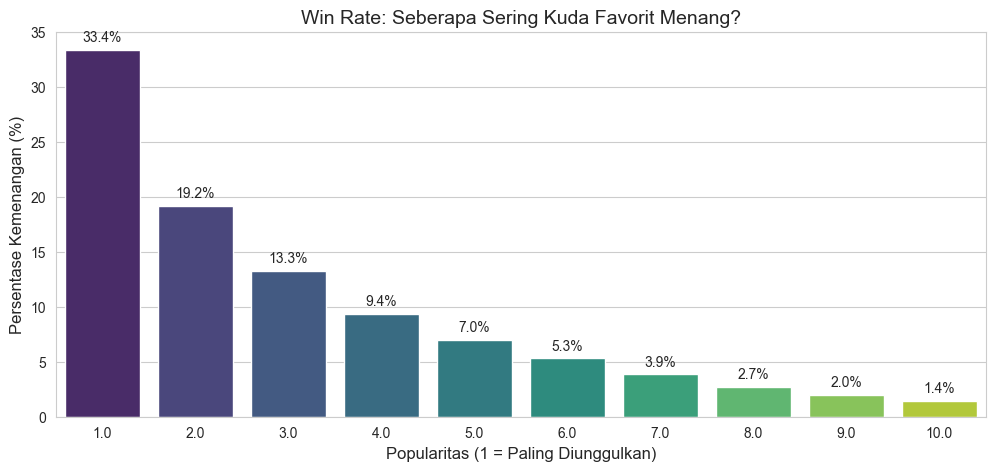

In [39]:
# Hitung Win Rate berdasarkan Popularitas (Ninki)
# Kita ambil hanya kuda yang Juara 1 (rank == 1)
win_data = df[df['rank'] == 1]
win_counts = win_data['popularity'].value_counts().sort_index()

# Hitung total balapan untuk persentase
total_races = df['race_id'].nunique()
win_rate = (win_counts / total_races) * 100

# Plotting
plt.figure(figsize=(12, 5))
ax = sns.barplot(x=win_rate.index[:10], y=win_rate.values[:10], palette="viridis") # Cek Top 10 Popularity saja

plt.title('Win Rate: Seberapa Sering Kuda Favorit Menang?', fontsize=14)
plt.xlabel('Popularitas (1 = Paling Diunggulkan)', fontsize=12)
plt.ylabel('Persentase Kemenangan (%)', fontsize=12)

# Label angka di atas bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')
plt.show()

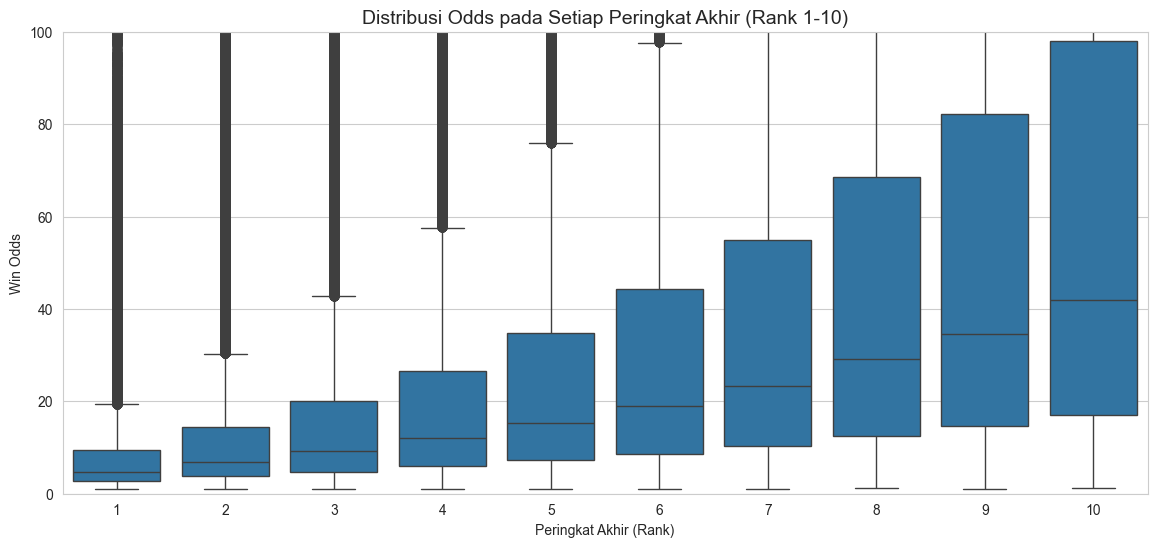

In [40]:
# Filter data agar plot tidak terlalu padat (Hanya Rank 1-10)
subset_df = df[df['rank'] <= 10].copy()

plt.figure(figsize=(14, 6))
sns.boxplot(x='rank', y='odds', data=subset_df)

plt.title('Distribusi Odds pada Setiap Peringkat Akhir (Rank 1-10)', fontsize=14)
plt.xlabel('Peringkat Akhir (Rank)')
plt.ylabel('Win Odds')
plt.ylim(0, 100) # Batasi tampilan odds max 100 agar outlier tidak merusak grafik
plt.show()

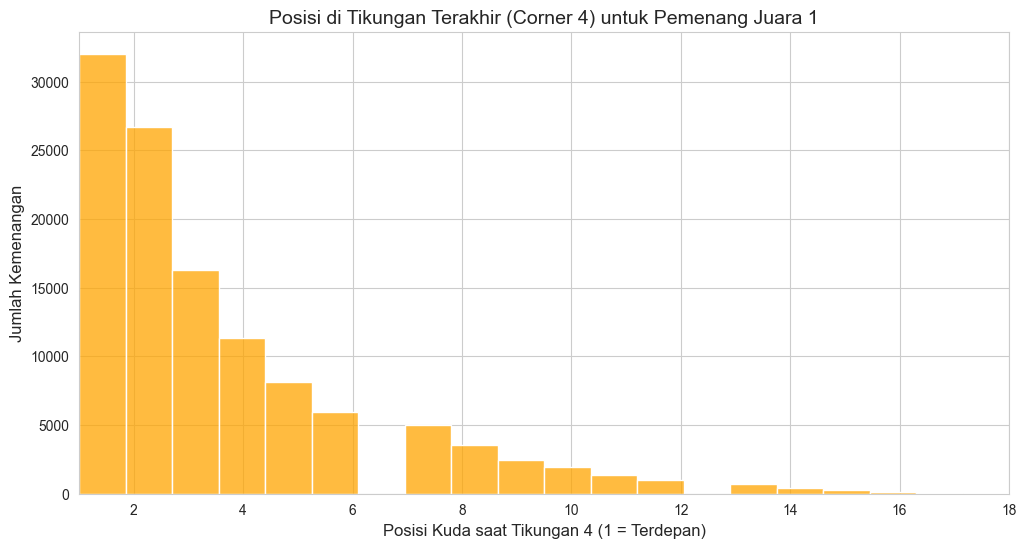

In [41]:
# Kita lihat posisi corner_4 dari kuda-kuda yang akhirnya Juara 1
winner_corner_pos = df[df['rank'] == 1]['corner_4']

plt.figure(figsize=(12, 6))
sns.histplot(winner_corner_pos, bins=20, kde=False, color='orange')

plt.title('Posisi di Tikungan Terakhir (Corner 4) untuk Pemenang Juara 1', fontsize=14)
plt.xlabel('Posisi Kuda saat Tikungan 4 (1 = Terdepan)', fontsize=12)
plt.ylabel('Jumlah Kemenangan', fontsize=12)
plt.xlim(1, 18) # Sesuai jumlah maksimal kuda
plt.show()

C:\Users\ACER\AppData\Local\Temp\ipykernel_6340\3464173065.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frame_win_rate.index, y=frame_win_rate.values, palette="magma")


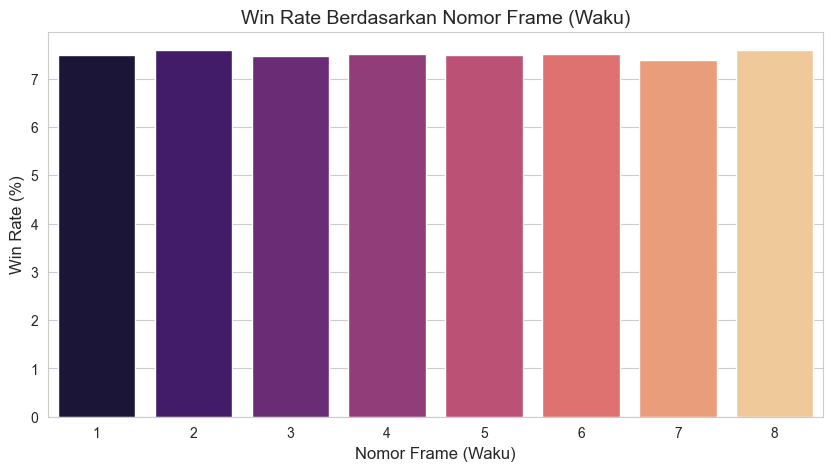

In [42]:
# Hitung Win Rate per Frame Number (Waku)
frame_wins = df[df['rank'] == 1]['frame_no'].value_counts().sort_index()
frame_total = df['frame_no'].value_counts().sort_index()
frame_win_rate = (frame_wins / frame_total) * 100

plt.figure(figsize=(10, 5))
sns.barplot(x=frame_win_rate.index, y=frame_win_rate.values, palette="magma")

plt.title('Win Rate Berdasarkan Nomor Frame (Waku)', fontsize=14)
plt.xlabel('Nomor Frame (Waku)', fontsize=12)
plt.ylabel('Win Rate (%)', fontsize=12)
plt.show()

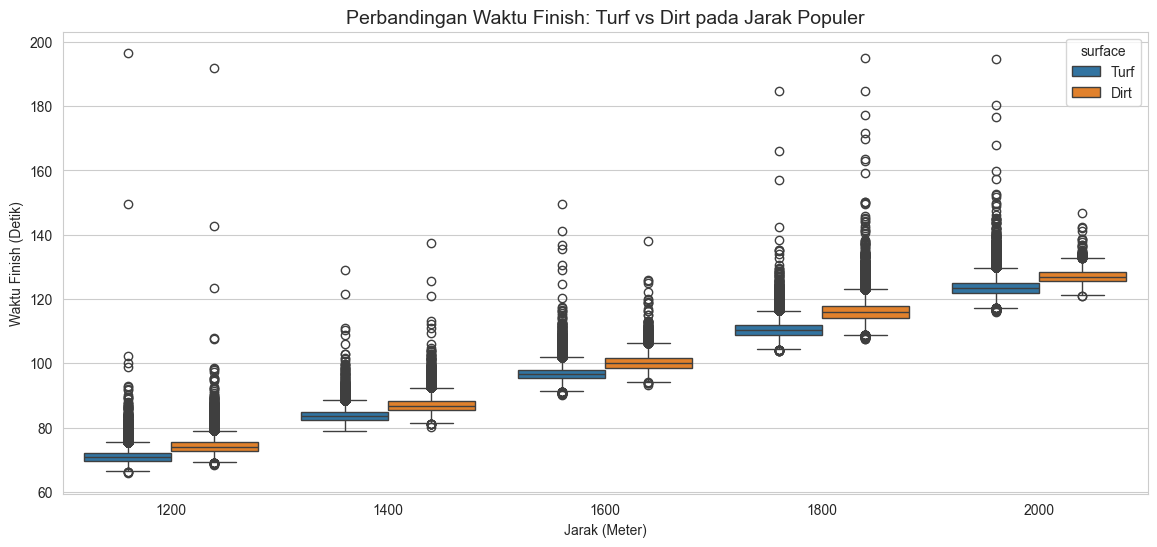

In [43]:
# Filter outlier waktu yang aneh (misal 0 detik atau terlalu lama)
valid_time = df[(df['time_seconds'] > 50) & (df['time_seconds'] < 200)]

plt.figure(figsize=(14, 6))
# Kita pisahkan berdasarkan jarak yang umum (misal 1200m, 1600m, 2000m)
common_distances = [1200, 1400, 1600, 1800, 2000]
subset_distance = valid_time[valid_time['distance'].isin(common_distances)]

sns.boxplot(x='distance', y='time_seconds', hue='surface', data=subset_distance)

plt.title('Perbandingan Waktu Finish: Turf vs Dirt pada Jarak Populer', fontsize=14)
plt.xlabel('Jarak (Meter)')
plt.ylabel('Waktu Finish (Detik)')
plt.show()

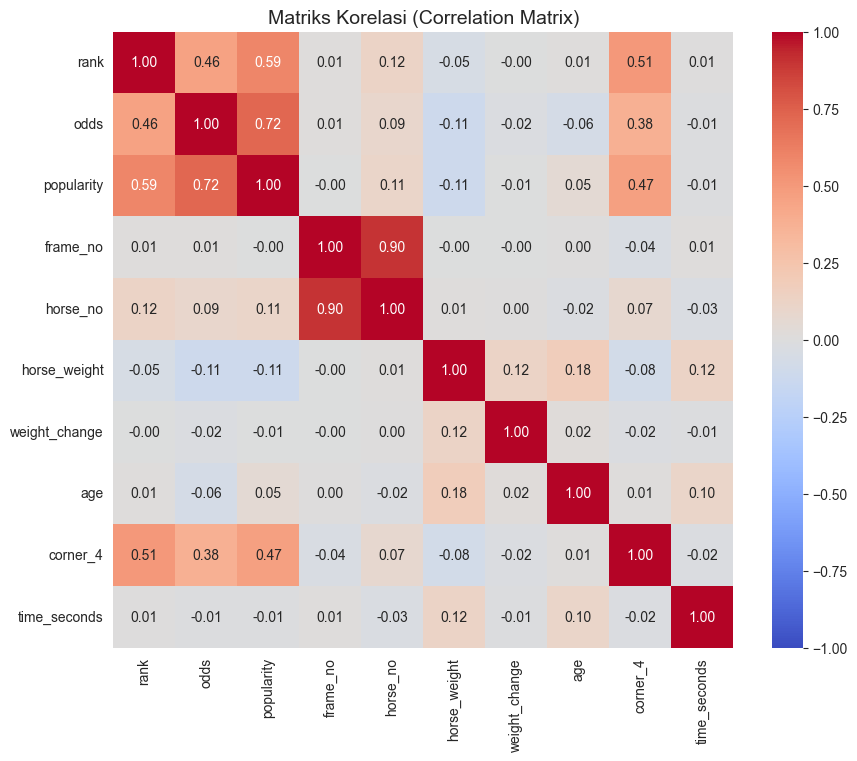

In [44]:
# Pilih kolom numerik yang relevan untuk korelasi
cols_corr = ['rank', 'odds', 'popularity', 'frame_no', 'horse_no', 
             'horse_weight', 'weight_change', 'age', 'corner_4', 'time_seconds']

corr_matrix = df[cols_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Matriks Korelasi (Correlation Matrix)', fontsize=14)
plt.show()

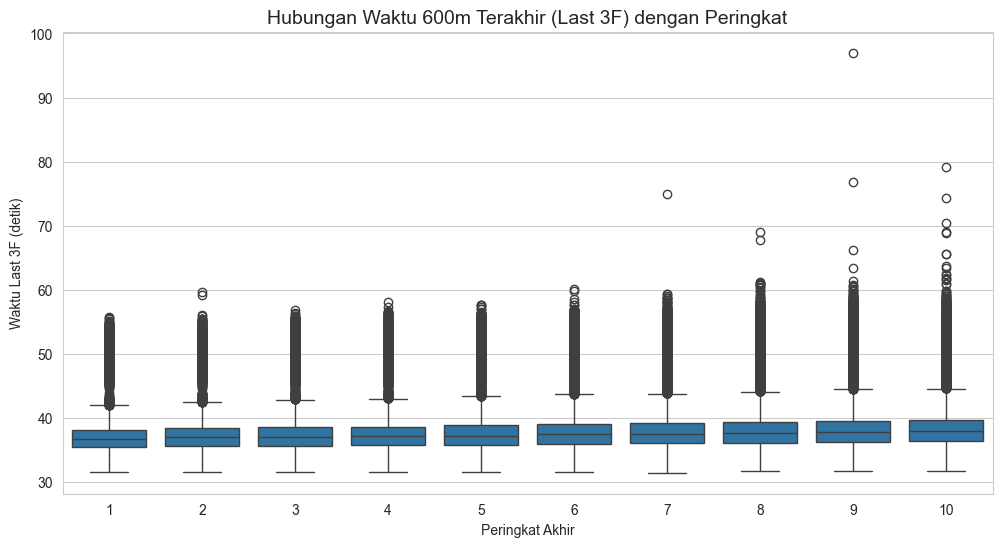

Korelasi antara Rank dan Last 3F: 0.12


In [45]:
# Filter data valid (hapus yang last_3f-nya 0 atau kosong)
df_valid_3f = df[df['last_3f'] > 30].copy()

plt.figure(figsize=(12, 6))
# Plot hubungan Last 3F dengan Rank
sns.boxplot(x='rank', y='last_3f', data=df_valid_3f[df_valid_3f['rank'] <= 10])

plt.title('Hubungan Waktu 600m Terakhir (Last 3F) dengan Peringkat', fontsize=14)
plt.xlabel('Peringkat Akhir')
plt.ylabel('Waktu Last 3F (detik)')
plt.show()

# Cek Korelasi
corr_3f = df_valid_3f[['rank', 'last_3f']].corr().iloc[0,1]
print(f"Korelasi antara Rank dan Last 3F: {corr_3f:.2f}")

C:\Users\ACER\AppData\Local\Temp\ipykernel_6340\3175462651.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weight_win_rate.values, y=weight_win_rate.index, palette="Reds")


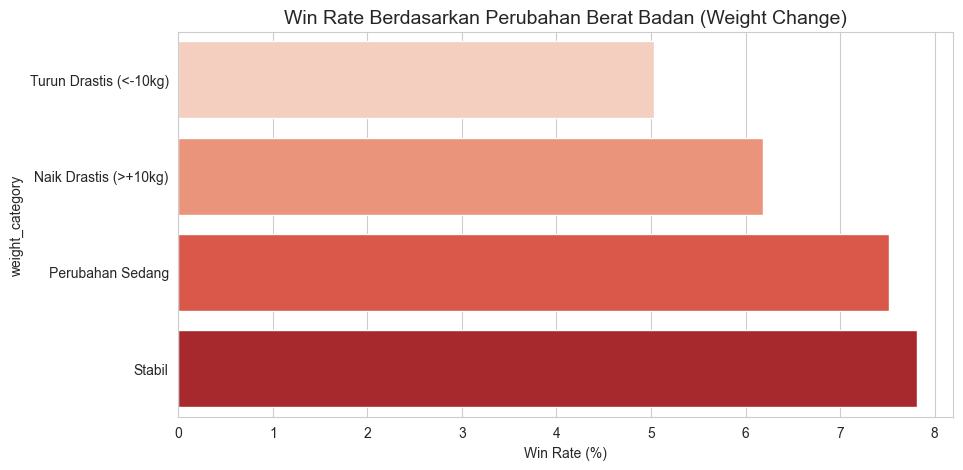

In [46]:
# Kita buat kategori perubahan berat badan
# Misal: Stabil (-2 s/d +2), Turun Banyak (<-10), Naik Banyak (>+10)
def categorize_weight(change):
    try:
        change = float(change)
        if change < -10: return 'Turun Drastis (<-10kg)'
        if change > 10: return 'Naik Drastis (>+10kg)'
        if -2 <= change <= 2: return 'Stabil'
        return 'Perubahan Sedang'
    except:
        return 'Unknown'

df['weight_category'] = df['weight_change'].apply(categorize_weight)

# Visualisasi Win Rate per kategori berat
weight_wins = df[df['rank'] == 1]['weight_category'].value_counts()
weight_total = df['weight_category'].value_counts()
weight_win_rate = (weight_wins / weight_total * 100).sort_values()

plt.figure(figsize=(10, 5))
sns.barplot(x=weight_win_rate.values, y=weight_win_rate.index, palette="Reds")
plt.title('Win Rate Berdasarkan Perubahan Berat Badan (Weight Change)', fontsize=14)
plt.xlabel('Win Rate (%)')
plt.show()

C:\Users\ACER\AppData\Local\Temp\ipykernel_6340\293988341.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=jockey_stats['Win_Rate'], y=jockey_stats.index, palette="Blues_r")


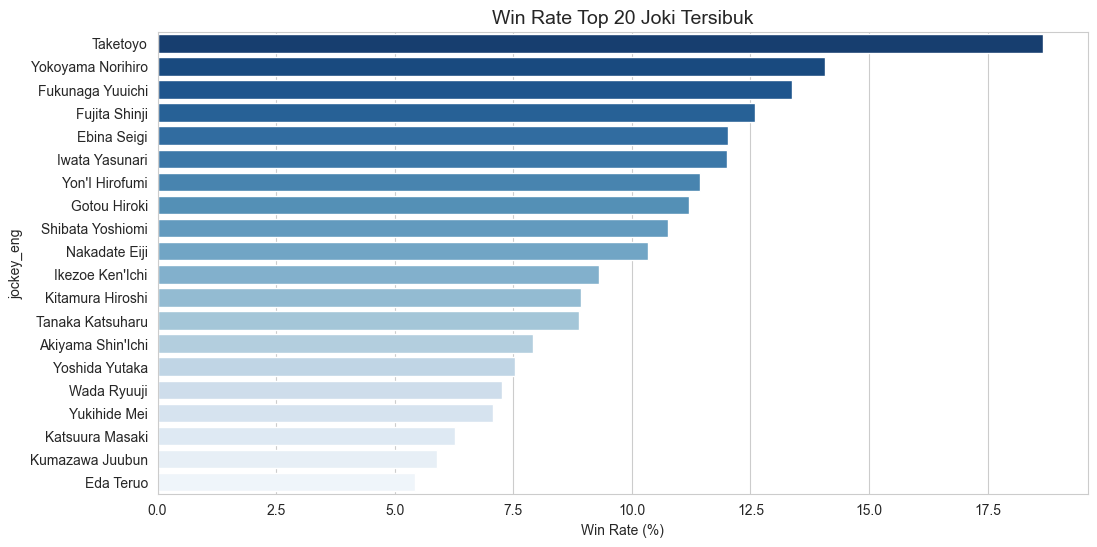

In [47]:
# Ambil Top 20 Joki dengan jumlah balapan terbanyak
top_jockeys = df['jockey_eng'].value_counts().nlargest(20).index

# Hitung Win Rate untuk Top 20 Joki tersebut
jockey_stats = df[df['jockey_eng'].isin(top_jockeys)].groupby('jockey_eng').agg(
    Total_Races=('race_id', 'count'),
    Total_Wins=('rank', lambda x: (x==1).sum())
)
jockey_stats['Win_Rate'] = (jockey_stats['Total_Wins'] / jockey_stats['Total_Races']) * 100
jockey_stats = jockey_stats.sort_values('Win_Rate', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=jockey_stats['Win_Rate'], y=jockey_stats.index, palette="Blues_r")
plt.title('Win Rate Top 20 Joki Tersibuk', fontsize=14)
plt.xlabel('Win Rate (%)')
plt.show()

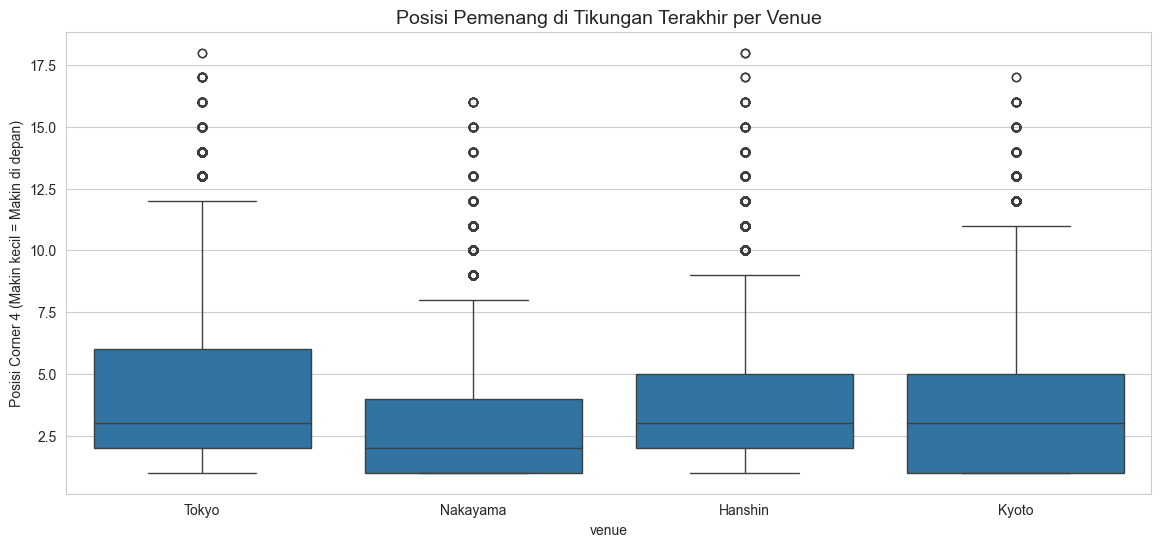

In [48]:
# Pilih 4 Venue Utama JRA
major_venues = ['Tokyo', 'Nakayama', 'Kyoto', 'Hanshin'] 
# Pastikan nama venue di data Anda sesuai (mungkin dalam huruf Jepang: 東京, 中山, dst)
# Jika data venue dalam bahasa Inggris, gunakan list di atas.

subset_venue = df[df['venue'].isin(major_venues) & (df['rank'] == 1)]

plt.figure(figsize=(14, 6))
# Kita lihat posisi corner_4 pemenang di tiap venue
sns.boxplot(x='venue', y='corner_4', data=subset_venue)
plt.title('Posisi Pemenang di Tikungan Terakhir per Venue', fontsize=14)
plt.ylabel('Posisi Corner 4 (Makin kecil = Makin di depan)')
plt.show()

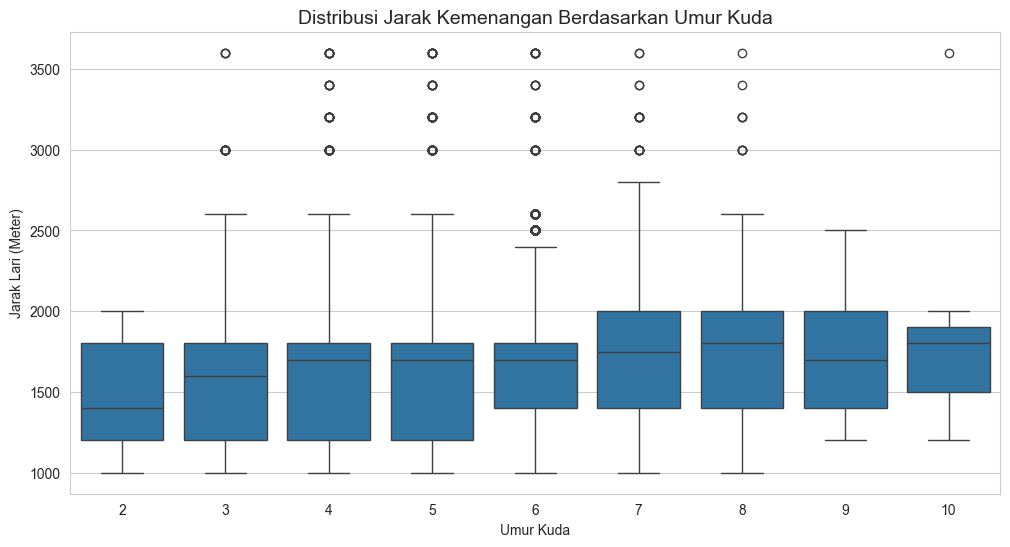

In [49]:
# Filter hanya Rank 1 (Pemenang)
winners = df[df['rank'] == 1]

plt.figure(figsize=(12, 6))
sns.boxplot(x='age', y='distance', data=winners)
plt.title('Distribusi Jarak Kemenangan Berdasarkan Umur Kuda', fontsize=14)
plt.xlabel('Umur Kuda')
plt.ylabel('Jarak Lari (Meter)')
plt.show()